In [76]:
import pandas as pd
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [77]:
file_path = 'weatherAUS_train.csv'
Aus_weather = pd.read_csv(file_path)
Aus_weather_test=pd.read_csv('weatherAUS_test.csv')

Data Analysis

In [78]:
# Display basic information of the dataset
print(Aus_weather.info())

# Display the first few rows of the dataset
print(Aus_weather.head())

# Basic statistical summary of numerical features
print(Aus_weather.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101822 entries, 0 to 101821
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           101822 non-null  object 
 1   Location       101822 non-null  object 
 2   MinTemp        100797 non-null  float64
 3   MaxTemp        100959 non-null  float64
 4   Rainfall       99540 non-null   float64
 5   Evaporation    57867 non-null   float64
 6   Sunshine       52902 non-null   float64
 7   WindGustDir    94636 non-null   object 
 8   WindGustSpeed  94677 non-null   float64
 9   WindDir9am     94426 non-null   object 
 10  WindDir3pm     98858 non-null   object 
 11  WindSpeed9am   100585 non-null  float64
 12  WindSpeed3pm   99684 non-null   float64
 13  Humidity9am    99946 non-null   float64
 14  Humidity3pm    98643 non-null   float64
 15  Pressure9am    91272 non-null   float64
 16  Pressure3pm    91286 non-null   float64
 17  Cloud9am       62689 non-null

In [79]:
# Calculate the percentage of missing data in each column
missing_percentage = Aus_weather.isnull().sum() * 100 / len(Aus_weather)

# Display the percentage of missing data for each column
print(missing_percentage)

Date              0.000000
Location          0.000000
MinTemp           1.006659
MaxTemp           0.847558
Rainfall          2.241166
Evaporation      43.168470
Sunshine         48.044627
WindGustDir       7.057414
WindGustSpeed     7.017148
WindDir9am        7.263656
WindDir3pm        2.910962
WindSpeed9am      1.214865
WindSpeed3pm      2.099743
Humidity9am       1.842431
Humidity3pm       3.122115
Pressure9am      10.361219
Pressure3pm      10.347469
Cloud9am         38.432755
Cloud3pm         40.804541
Temp9am           1.217811
Temp3pm           2.493567
RainToday         2.241166
RainTomorrow      2.228399
dtype: float64


In [80]:
def preprocess_weather_data(df):
    # Impute missing values for numerical columns
    missing_percentage = df.isnull().sum() * 100 / len(df)
    print(missing_percentage)
    #drop columns with more than 30% missing values
    df = df.dropna(thresh=len(df) * 0.7, axis=1)
    num_cols = df.select_dtypes(include=[np.number]).columns
    imputer_num = SimpleImputer(strategy='median')
    df[num_cols] = imputer_num.fit_transform(df[num_cols])

    df.drop(['Location','Date'],axis=1,inplace=True)
    # Impute missing values for remaining categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

    # #use onehot encoding for categorical columns
    # df = pd.get_dummies(df, columns=cat_cols)
    # Encode categorical variables
    label_encoders = {}
    for column in cat_cols:
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column].astype(str))
        label_encoders[column] = label_encoder

    print(df.head())
    print(df.info())
    print(df.describe())
    return df, num_cols

In [81]:
# #drop the column
# Aus_weather = Aus_weather.drop(['Date'], axis=1)
# categorical_data = Aus_weather.select_dtypes(include=['object'])
# Aus_weather = Aus_weather.drop(categorical_data, axis=1)

# numerical_data = Aus_weather.select_dtypes(include=[np.number])
# # # Apply one-hot encoding
# # encoded_data = pd.get_dummies(categorical_data)

# # numerical_data=pd.concat([numerical_data, encoded_data], axis=1)

# # Drop the columns with more than 30% missing data
# numerical_data = numerical_data.dropna(thresh=len(Aus_weather)*0.7, axis=1)
# # use imputer to fill the missing data

# # Create an imputer object with a mean filling strategy
# imputer = SimpleImputer(strategy='mean')

# # Apply the imputer to our data
# # imputer.fit_transform returns a numpy array, so we need to convert it back to a DataFrame
# imputed_data = pd.DataFrame(imputer.fit_transform(numerical_data), columns=numerical_data.columns)

# # Check the imputed data
# print(imputed_data.head())

Date              0.000000
Location          0.000000
MinTemp           1.006659
MaxTemp           0.847558
Rainfall          2.241166
Evaporation      43.168470
Sunshine         48.044627
WindGustDir       7.057414
WindGustSpeed     7.017148
WindDir9am        7.263656
WindDir3pm        2.910962
WindSpeed9am      1.214865
WindSpeed3pm      2.099743
Humidity9am       1.842431
Humidity3pm       3.122115
Pressure9am      10.361219
Pressure3pm      10.347469
Cloud9am         38.432755
Cloud3pm         40.804541
Temp9am           1.217811
Temp3pm           2.493567
RainToday         2.241166
RainTomorrow      2.228399
dtype: float64


/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_15617/3776888901.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = imputer_num.fit_transform(df[num_cols])
/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_15617/3776888901.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Location','Date'],axis=1,inplace=True)
/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_15617/3776888901.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

   MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  WindDir9am   
0     22.2     34.2       0.0            0           48.0           9  \
1     16.9     31.4       0.0            0           20.0          15   
2      8.8     20.9       2.4           13           39.0           3   
3     12.0     22.6       0.0            9           28.0          11   
4     11.8     21.3       1.2            8           35.0          11   

   WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm   
0           0          19.0          19.0         66.0         27.0  \
1           1           7.0           7.0         50.0         50.0   
2           9          28.0          19.0         39.0         52.0   
3          10          11.0          19.0         70.0         52.0   
4          10          13.0          17.0         75.0         60.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1013.3       1009.4     25.7     33.4          0     

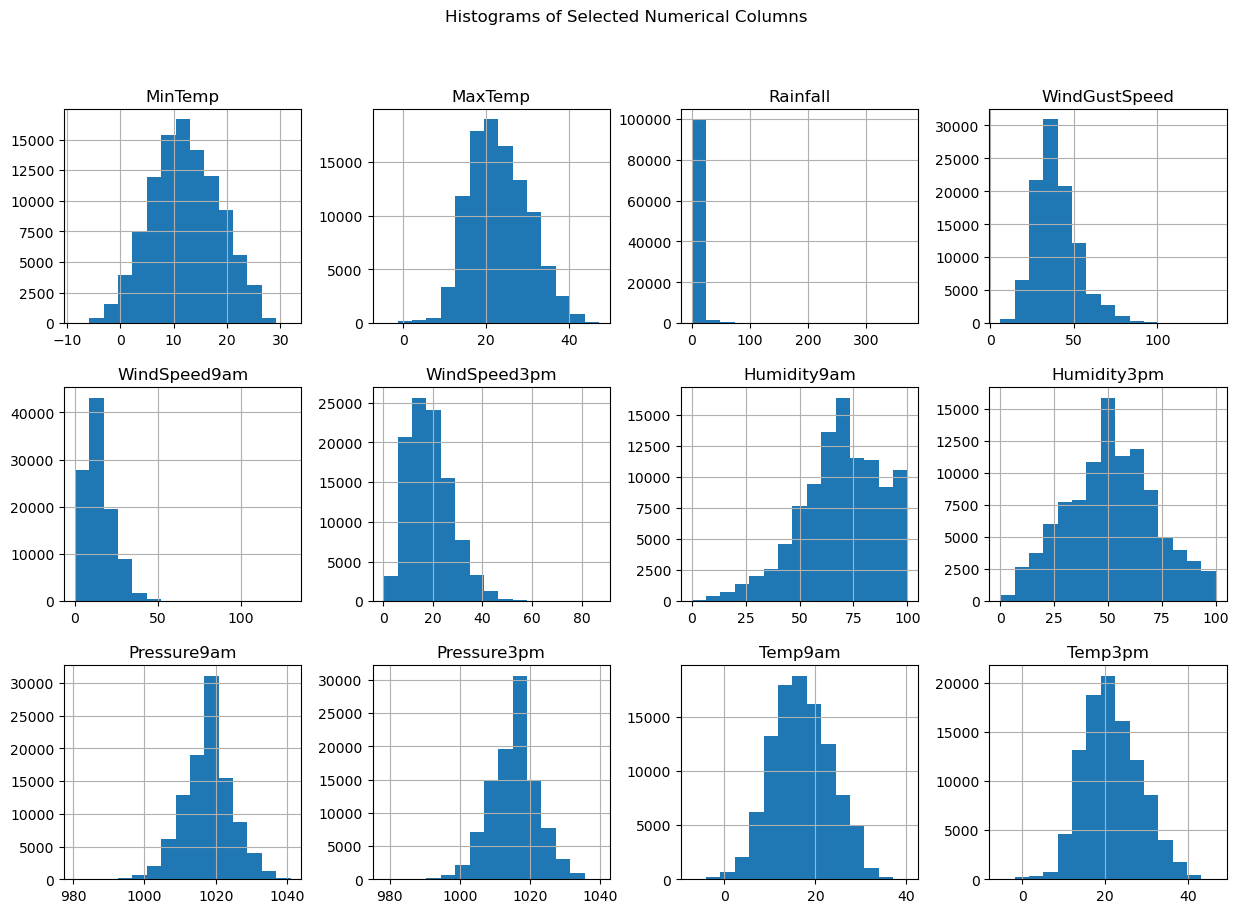

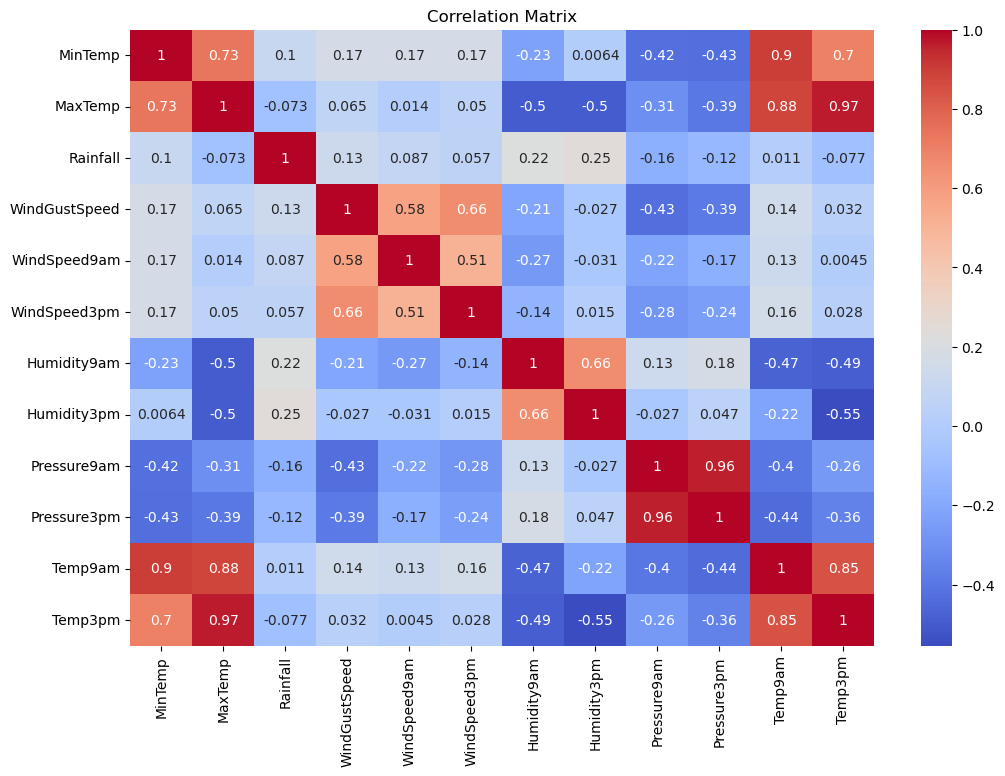

In [82]:
Aus_weather_train, num_cols = preprocess_weather_data(Aus_weather)
numerical_data = Aus_weather_train[num_cols]
numerical_data.hist(bins=15, figsize=(15, 10), layout=(3, 4))
plt.suptitle('Histograms of Selected Numerical Columns')
plt.show()

# Generating a correlation matrix
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

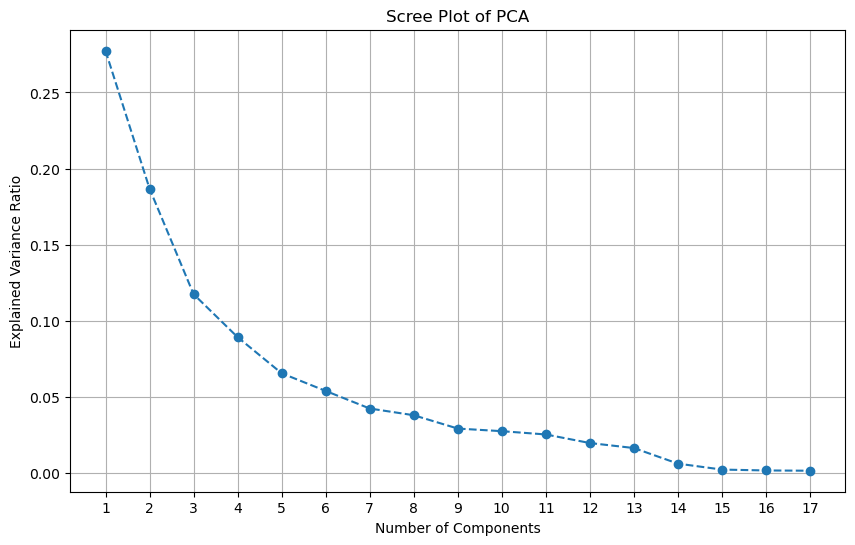

In [83]:
# Standardizing the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Aus_weather_train)

# Applying PCA
pca = PCA()  # Not specifying the number of components to compute all
pca.fit(scaled_data)

# Getting the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Generating the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot of PCA')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

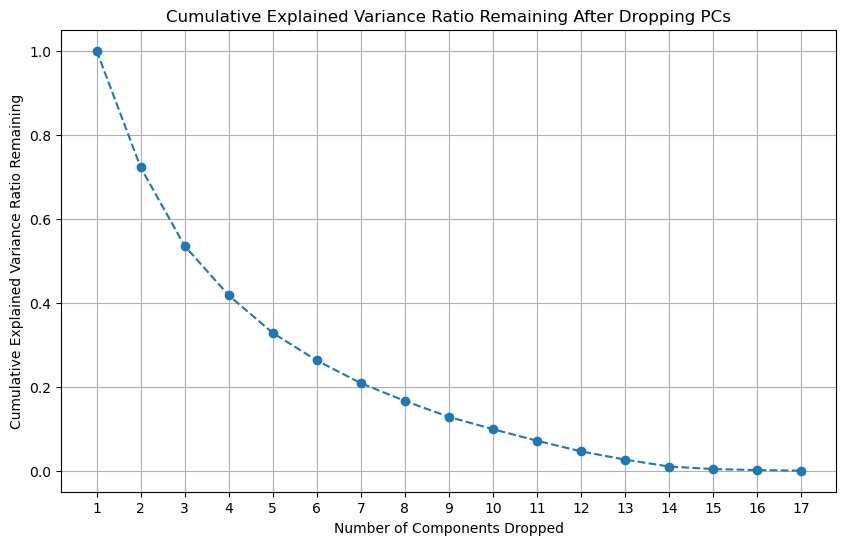

In [84]:
# Calculate the cumulative explained variance ratio in reverse
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_[::-1])[::-1]

# Generating the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance Ratio Remaining After Dropping PCs')
plt.xlabel('Number of Components Dropped')
plt.ylabel('Cumulative Explained Variance Ratio Remaining')
plt.xticks(range(1, len(cumulative_variance_ratio) + 1))
plt.grid(True)
plt.show()

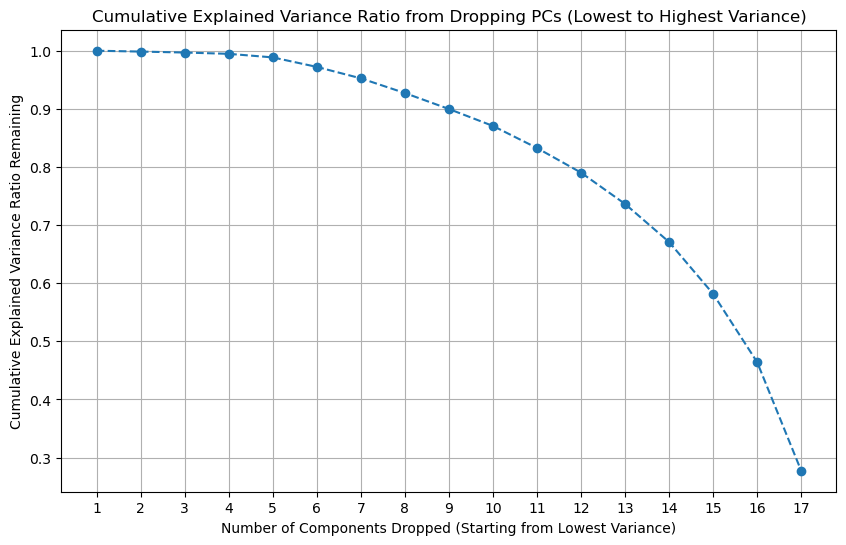

In [85]:
# Sort the explained variance ratios in ascending order
sorted_variance_ratios = np.sort(pca.explained_variance_ratio_)

# Calculate the cumulative explained variance ratio in reverse after sorting
cumulative_variance_ratio = np.cumsum(sorted_variance_ratios[::-1])[::-1]

# Generating the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance Ratio from Dropping PCs (Lowest to Highest Variance)')
plt.xlabel('Number of Components Dropped (Starting from Lowest Variance)')
plt.ylabel('Cumulative Explained Variance Ratio Remaining')
plt.xticks(range(1, len(cumulative_variance_ratio) + 1))
plt.grid(True)
plt.show()

In [86]:
#Variance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Adding a constant column for intercept
X = imputed_data.copy()
X['Intercept'] = 1

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [87]:
file_path = 'weatherAUS_train.csv'
Aus_weather = pd.read_csv(file_path)
Aus_weather_test=pd.read_csv('weatherAUS_test.csv')

In [88]:
Aus_weather['Date'] = pd.to_datetime(Aus_weather['Date'])
def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'
Aus_weather['Season'] = Aus_weather['Date'].apply(get_season)
df_spring = Aus_weather[Aus_weather['Season'] == 'Spring'].drop(['Season'], axis=1)
df_summer = Aus_weather[Aus_weather['Season'] == 'Summer'].drop(['Season'], axis=1)
df_autumn = Aus_weather[Aus_weather['Season'] == 'Autumn'].drop(['Season'], axis=1)
df_winter = Aus_weather[Aus_weather['Season'] == 'Winter'].drop(['Season'], axis=1)

In [89]:
spring_df = preprocess_weather_data(df_spring)[0]
summer_df = preprocess_weather_data(df_summer)[0]
autumn_df = preprocess_weather_data(df_autumn)[0]
winter_df = preprocess_weather_data(df_winter)[0]
print(spring_df[spring_df['RainTomorrow']==1].shape)
print(spring_df[spring_df['RainTomorrow']==0].shape)

Date              0.000000
Location          0.000000
MinTemp           1.135512
MaxTemp           0.884425
Rainfall          2.274771
Evaporation      43.614151
Sunshine         48.534702
WindGustDir       6.846800
WindGustSpeed     6.786839
WindDir9am        9.556288
WindDir3pm        2.825663
WindSpeed9am      1.019337
WindSpeed3pm      1.840054
Humidity9am       2.237296
Humidity3pm       3.410283
Pressure9am      10.129666
Pressure3pm      10.133413
Cloud9am         38.787288
Cloud3pm         41.043322
Temp9am           1.454055
Temp3pm           2.627042
RainToday         2.274771
RainTomorrow      2.207315
dtype: float64
    MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  WindDir9am   
1      16.9     31.4       0.0            0           20.0          15  \
4      11.8     21.3       1.2            8           35.0          11   
5      15.0     20.4       9.6           11           35.0          11   
9      10.1     19.1       0.0           12           65.0          

/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_15617/3776888901.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = imputer_num.fit_transform(df[num_cols])
/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_15617/3776888901.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Location','Date'],axis=1,inplace=True)
/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_15617/3776888901.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

    MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  WindDir9am   
2       8.8     20.9       2.4           13           41.0           3  \
3      11.5     22.7       0.0            9           28.0          11   
7      12.7     17.8       2.6           15           72.0          13   
10      8.4     26.4       0.0            1           33.0           0   
11      6.4     15.6       0.8           13           41.0           6   

    WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm   
2           13          28.0          20.0         39.0         50.0  \
3           10          11.0          19.0         64.0         50.0   
7           15          15.0          24.0         71.0         72.0   
10           5          11.0           9.0         57.0         23.0   
11          14          30.0          31.0         96.0         61.0   

    Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
2        1017.3       1014.8     17.0     21.0  

/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_15617/3776888901.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = label_encoder.fit_transform(df[column].astype(str))
/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_15617/3776888901.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = label_encoder.fit_transform(df[column].astype(str))
/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_15617/3776888901.py:23: SettingWithCopyWarning: 
A value is tryin

In [90]:
# Display basic information of the dataset
print(spring_df.info())

# Display the first few rows of the dataset
print(spring_df.head())

# Basic statistical summary of numerical features
print(spring_df.describe())

print(spring_df['RainToday'])

<class 'pandas.core.frame.DataFrame'>
Index: 26684 entries, 1 to 101821
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        26684 non-null  float64
 1   MaxTemp        26684 non-null  float64
 2   Rainfall       26684 non-null  float64
 3   WindGustDir    26684 non-null  int64  
 4   WindGustSpeed  26684 non-null  float64
 5   WindDir9am     26684 non-null  int64  
 6   WindDir3pm     26684 non-null  int64  
 7   WindSpeed9am   26684 non-null  float64
 8   WindSpeed3pm   26684 non-null  float64
 9   Humidity9am    26684 non-null  float64
 10  Humidity3pm    26684 non-null  float64
 11  Pressure9am    26684 non-null  float64
 12  Pressure3pm    26684 non-null  float64
 13  Temp9am        26684 non-null  float64
 14  Temp3pm        26684 non-null  float64
 15  RainToday      26684 non-null  int64  
 16  RainTomorrow   26684 non-null  int64  
dtypes: float64(12), int64(5)
memory usage: 3.7 MB
None
   

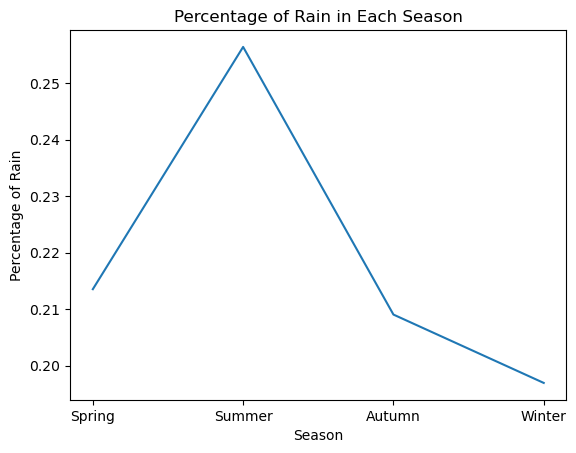

In [91]:
#draw the graph of the percentage of rain in each season
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
rainy_days = [spring_df[spring_df['RainToday']==1].shape[0], summer_df[summer_df['RainToday']==1].shape[0], autumn_df[autumn_df['RainToday']==1].shape[0], winter_df[winter_df['RainToday']==1].shape[0]]
total_days = [spring_df.shape[0], summer_df.shape[0], autumn_df.shape[0], winter_df.shape[0]]
percentage = [rainy_days[i]/total_days[i] for i in range(4)]
plt.plot(seasons, percentage)
plt.xlabel('Season')
plt.ylabel('Percentage of Rain')
plt.title('Percentage of Rain in Each Season')
plt.show()


In [92]:
len(df_spring)

26684

In [93]:
# def undersampling(data, target, i):
#     data, _ = preprocess_weather_data(data)
#     X = data.drop(target, axis=1)
#     y = data[target]
#     tl = TomekLinks()
#     enn = EditedNearestNeighbours()
#     X_resampled, y_resampled = enn.fit_resample(X, y)
#     resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
#     resampled_data[target] = y_resampled
#     resampled_data.to_csv(f'{i}_ENN.csv', index=False)

In [94]:
# seasonable_datas = [df_spring, df_summer, df_autumn, df_winter]
# for i in range(4):
#     undersampling(seasonable_datas[i], 'RainTomorrow', i)

In [95]:
X = spring_df.drop(['RainTomorrow'], axis=1)
y = spring_df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [96]:
# smote=SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [98]:
#grid search on balanced random forest
param_grid = {'n_estimators': [100,300], 'max_depth': [None,5,6], 'min_samples_leaf': [2,3], 'class_weight': ['balanced',None]}
BRF = BalancedRandomForestClassifier(random_state=42)
grid_search = GridSearchCV(BRF, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
brf = RandomForestClassifier(**grid_search.best_params_,random_state=42)
# model.fit(X_train_pca, y_train)
# y_pred_pca = model.predict(X_test_pca)
brf.fit(X_train_scaled, y_train)
y_pred = brf.predict(X_test_scaled)
# accuracy_pca = accuracy_score(y_test, y_pred_pca)
# classification_rep_pca = classification_report(y_test, y_pred_pca)
accuracy_pca = accuracy_score(y_test, y_pred)
classification_rep_pca = classification_report(y_test, y_pred)
print(classification_rep_pca)


/Users/bobby/opt/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/bobby/opt/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/bobby/opt/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adop

{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 300}
0.7951939887967445
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4178
           1       0.74      0.47      0.57      1159

    accuracy                           0.85      5337
   macro avg       0.80      0.71      0.74      5337
weighted avg       0.84      0.85      0.84      5337



In [99]:
weights = np.where(y_train == 0, 1, 20)

In [100]:
#use grid search to find the best parameters
param_grid = {'n_estimators': [100,300], 'max_depth': [None,5,6], 'min_samples_leaf': [2,3]}
RF = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train, sample_weight=weights)
print(grid_search.best_params_)
print(grid_search.best_score_)
RF = RandomForestClassifier(**grid_search.best_params_,random_state=42)
# model.fit(X_train_pca, y_train)
# y_pred_pca = model.predict(X_test_pca)
RF.fit(X_train_scaled, y_train, sample_weight=weights)
y_pred = RF.predict(X_test_scaled)
# accuracy_pca = accuracy_score(y_test, y_pred_pca)
# classification_rep_pca = classification_report(y_test, y_pred_pca)
accuracy_pca = accuracy_score(y_test, y_pred)
classification_rep_pca = classification_report(y_test, y_pred)
print(classification_rep_pca)

{'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 300}
0.8460675431999004
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4178
           1       0.69      0.54      0.60      1159

    accuracy                           0.85      5337
   macro avg       0.78      0.74      0.75      5337
weighted avg       0.84      0.85      0.84      5337



In [101]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [102]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Assuming X_train_scaled, y_train, X_test_scaled, y_test, and X are already defined

# Define the parameter grid
param_grid = {
    'n_estimators': [100,300,500],
    'max_depth': [None,4,5,6],
    'learning_rate': [0.05,0.1],
    'scale_pos_weight': [scale_pos_weight]
}

# Create a XGBClassifier instance
xgbtest = xgb.XGBClassifier(objective='binary:logistic')

# Set up GridSearchCV
grid_search = GridSearchCV(xgbtest, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Create a new model with the best parameters
XGB = xgb.XGBClassifier(objective='binary:logistic', **grid_search.best_params_)
XGB.fit(X_train_scaled, y_train)

# Make predictions
y_pred = XGB.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns, 
    'importance': XGB.feature_importances_
}).sort_values('importance', ascending=False)

# Print the top 3 features
print(feature_importance.head(3))


KeyboardInterrupt: 

In [ ]:
#logistic regression
from sklearn.linear_model import LogisticRegression
#use grid search to find the best parameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print(grid.best_params_)
print(grid.best_score_)
logreg = LogisticRegression(**grid.best_params_)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep_pca = classification_report(y_test, y_pred)
print(classification_rep_pca)

{'C': 0.1}
0.8442062727694374
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5998
           1       0.74      0.47      0.57      1655

    accuracy                           0.85      7653
   macro avg       0.80      0.71      0.74      7653
weighted avg       0.84      0.85      0.84      7653



In [ ]:
smote=SMOTE(random_state=42, sampling_strategy=0.8)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
# scaler = StandardScaler()
# X_train_scaled_smote = scaler.fit_transform(X_train_smote)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_smote.astype(np.float32))
y_train_tensor = torch.tensor(y_train_smote.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

NN = NeuralNet()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(NN.parameters(), lr=0.001)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    NN.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = NN(inputs).squeeze()  # Adjusting the output shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Modify the evaluation code to save the raw probabilities
NN.eval()
y_pred_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = NN(inputs).squeeze()  # Get the raw probabilities
        y_pred_probs.extend(outputs.numpy())

# Convert to a numpy array
NNy_pred_prob = np.array(y_pred_probs).flatten()



# Compute classification report
classification_rep = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(classification_rep)
#save the best model
torch.save(NN.state_dict(), 'NN.ckpt')

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5998
           1       0.74      0.47      0.57      1655

    accuracy                           0.85      7653
   macro avg       0.80      0.71      0.74      7653
weighted avg       0.84      0.85      0.84      7653



In [ ]:
#Complex NN
X_train_tensor = torch.tensor(X_train_smote.astype(np.float32))
y_train_tensor = torch.tensor(y_train_smote.astype(np.float32))
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modified Model definition with more layers and units
class ComplexNeuralNet(nn.Module):
    def __init__(self, input_size):
        super(ComplexNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.6)
        self.fc4 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.dropout3(x)
        x = self.relu4(self.fc4(x))
        x = self.dropout4(x)
        x = self.sigmoid(self.fc5(x))
        return x

# Initialize the model
input_size = X_train_tensor.shape[1]
ComNN = ComplexNeuralNet(input_size)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(ComNN.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    ComNN.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = ComNN(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model to save the raw probabilities
ComNN.eval()
y_pred_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = ComNN(inputs).squeeze()
        y_pred_probs.extend(outputs.numpy())

# Convert to a numpy array
ComNNy_pred_prob = np.array(y_pred_probs).flatten()

# Threshold the probabilities to create class predictions
Comy_pred = (ComNNy_pred_prob > 0.5).astype(int)

# Compute classification report
classification_rep = classification_report(y_test, Comy_pred)

# Print the classification report
print("Classification Report:")
print(classification_rep)

#save the best model
torch.save(ComNN.state_dict(), 'ComNN.ckpt')

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      5998
           1       0.59      0.72      0.65      1655

    accuracy                           0.83      7653
   macro avg       0.75      0.79      0.77      7653
weighted avg       0.85      0.83      0.84      7653



NN: ROC AUC=0.874
Complex NN: ROC AUC=0.875
RF: ROC AUC=0.882
XGB: ROC AUC=0.883
Logistic Regression: ROC AUC=0.862
Balanced Random Forest: ROC AUC=0.883


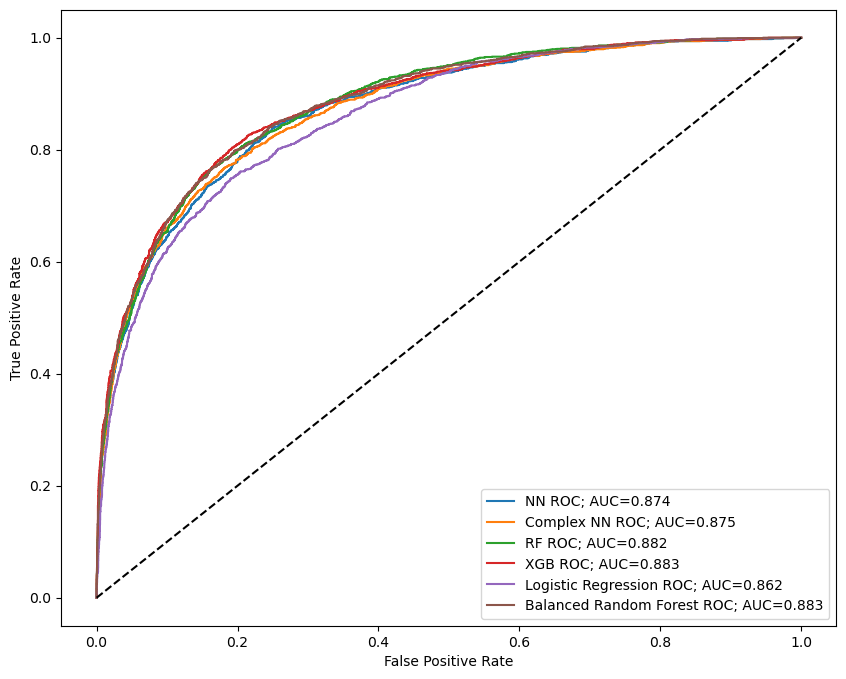

In [ ]:
#draw the auc and roc graph of the models above
# Compute predicted probabilities: y_pred_prob

rfy_pred_prob = RF.predict_proba(X_test_scaled)[:,1]
rfy_pred=RF.predict(X_test_scaled)
print("RF predication report:")
print(classification_report(y_test, rfy_pred))
xgby_pred_prob = XGB.predict_proba(X_test_scaled)[:,1]
xgby_pred=XGB.predict(X_test_scaled)
print("XGB predication report:")
print(classification_report(y_test, xgby_pred_prob))
logy_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]
logy_pred=logreg.predict(X_test_scaled)
print("Logistic Regression predication report:")
print(classification_report(y_test, logy_pred))
brfy_pred_prob = brf.predict_proba(X_test_scaled)[:,1]
brfy_pred=brf.predict(X_test_scaled)
print("Balanced Random Forest predication report:")
print(classification_report(y_test, brfy_pred))
plt.figure(figsize=(10,8))
#generate the auc score
NN_auc = roc_auc_score(y_test, NNy_pred_prob)
ComNN_auc = roc_auc_score(y_test, ComNNy_pred_prob)
rf_auc = roc_auc_score(y_test, rfy_pred_prob)
xgb_auc = roc_auc_score(y_test, xgby_pred_prob)
log_auc = roc_auc_score(y_test, logy_pred_prob)
brf_auc = roc_auc_score(y_test, brfy_pred_prob)
print('NN: ROC AUC=%.3f' % (NN_auc))
print('Complex NN: ROC AUC=%.3f' % (ComNN_auc))
print('RF: ROC AUC=%.3f' % (rf_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))
print('Logistic Regression: ROC AUC=%.3f' % (log_auc))
print('Balanced Random Forest: ROC AUC=%.3f' % (brf_auc))
# Generate ROC curve values: fpr, tpr, thresholds
NNfpr, NNtpr, NNthresholds = roc_curve(y_test, NNy_pred_prob)
ComNNfpr, ComNNtpr, ComNNthresholds = roc_curve(y_test, ComNNy_pred_prob)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rfy_pred_prob)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgby_pred_prob)
log_fpr, log_tpr, log_thresholds = roc_curve(y_test, logy_pred_prob)
brf_fpr, brf_tpr, brf_thresholds = roc_curve(y_test, brfy_pred_prob)
# Plot ROC curve
plt.plot(NNfpr, NNtpr, label='NN ROC; AUC=%.3f' % (NN_auc))
plt.plot(ComNNfpr, ComNNtpr, label='Complex NN ROC; AUC=%.3f' % (ComNN_auc))
plt.plot(rf_fpr, rf_tpr, label='RF ROC; AUC=%.3f' % (rf_auc))
plt.plot(xgb_fpr, xgb_tpr, label='XGB ROC; AUC=%.3f' % (xgb_auc))
plt.plot(log_fpr, log_tpr, label='Logistic Regression ROC; AUC=%.3f' % (log_auc))
plt.plot(brf_fpr, brf_tpr, label='Balanced Random Forest ROC; AUC=%.3f' % (brf_auc))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Label axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show the plot
plt.legend()
plt.show()






In [ ]:
#draw the confusion matrix of the models above
# Generate confusion matrix
NN_matrix = confusion_matrix(y_test, y_pred)
ComNN_matrix = confusion_matrix(y_test, Comy_pred)
rf_matrix = confusion_matrix(y_test, RF.predict(X_test_scaled))
xgb_matrix = confusion_matrix(y_test, XGB.predict(X_test_scaled))
log_matrix = confusion_matrix(y_test, logreg.predict(X_test_scaled))
brf_matrix = confusion_matrix(y_test, brf.predict(X_test_scaled))
# Print the confusion matrix
print(NN_matrix)
print(rf_matrix)
print(xgb_matrix)
print(log_matrix)
print(brf_matrix)

[[5726  272]
 [ 883  772]]
[[5622  376]
 [ 721  934]]
[[5269  729]
 [ 489 1166]]
[[5726  272]
 [ 883  772]]
[[5749  249]
 [ 819  836]]


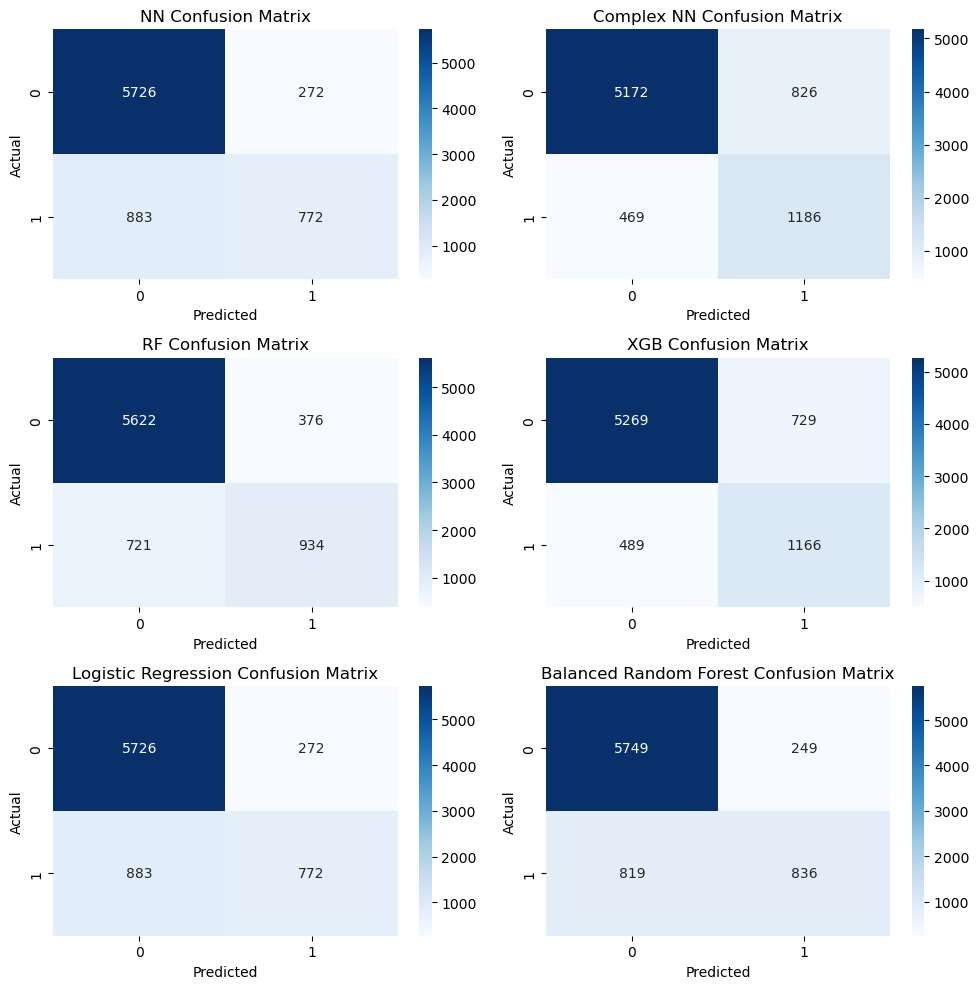

In [ ]:
#plot the confusion matrix
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
sns.heatmap(NN_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('NN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,2)
sns.heatmap(ComNN_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Complex NN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,3)
sns.heatmap(rf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,4)
sns.heatmap(xgb_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('XGB Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,5)
sns.heatmap(log_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,6)
sns.heatmap(brf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Balanced Random Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

Testing

In [ ]:
testset=preprocess_weather_data(Aus_weather_test)[0]
y_test=testset['RainTomorrow']
X_test=testset.drop(['RainTomorrow'], axis=1)

In [ ]:
StandardScaler = StandardScaler()
X_test_scaled= StandardScaler.fit_transform(X_test)

In [ ]:
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))

# Create TensorDatasets and DataLoaders
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
NN.eval()
y_pred_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = NN(inputs).squeeze()  # Get the raw probabilities
        y_pred_probs.extend(outputs.numpy())
        
# Convert to a numpy array
NNy_pred_prob = np.array(y_pred_probs).flatten()

NNy_pred= (NNy_pred_prob > 0.5).astype(int)


In [ ]:
ComNN.eval()
y_pred_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = ComNN(inputs).squeeze()  # Get the raw probabilities
        y_pred_probs.extend(outputs.numpy())
        
# Convert to a numpy array
ComNNy_pred_prob = np.array(y_pred_probs).flatten()

ComNNy_pred= (ComNNy_pred_prob > 0.5).astype(int)

NN: ROC AUC=0.874
Complex NN: ROC AUC=0.875
RF: ROC AUC=0.882
XGB: ROC AUC=0.883
Logistic Regression: ROC AUC=0.862
Balanced Random Forest: ROC AUC=0.883


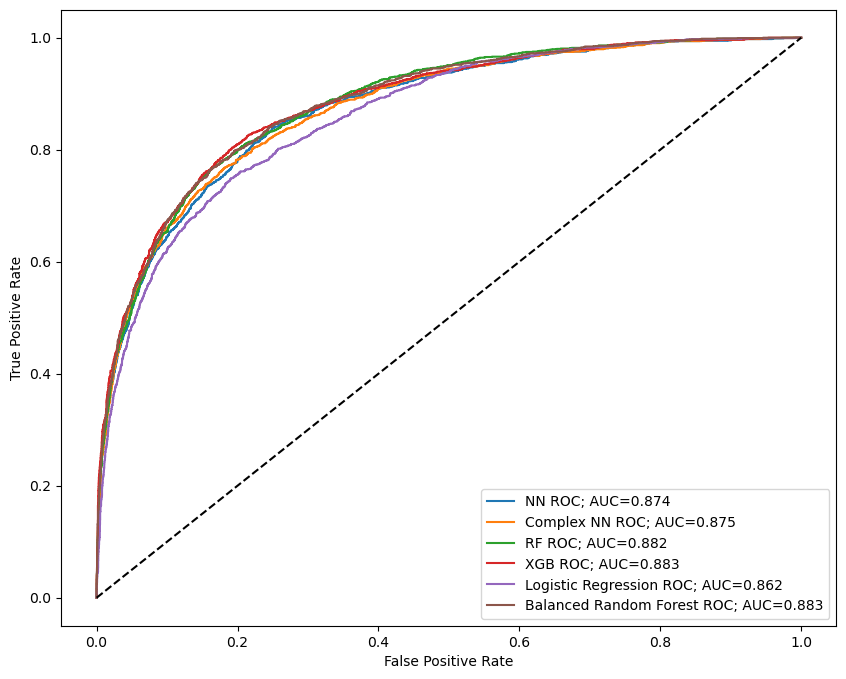

In [ ]:
#draw the auc and roc graph of the models above
# Compute predicted probabilities: y_pred_prob
print("NN predication report:")
print(classification_report(y_test, NNy_pred))
print("Complex NN predication report:")
print(classification_report(y_test, ComNNy_pred))
rfy_pred_prob = RF.predict_proba(X_test_scaled)[:,1]
rfy_pred=RF.predict(X_test_scaled)
print("RF predication report:")
print(classification_report(y_test, rfy_pred))
xgby_pred_prob = XGB.predict_proba(X_test_scaled)[:,1]
xgby_pred=XGB.predict(X_test_scaled)
print("XGB predication report:")
print(classification_report(y_test, xgby_pred_prob))
logy_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]
logy_pred=logreg.predict(X_test_scaled)
print("Logistic Regression predication report:")
print(classification_report(y_test, logy_pred))
brfy_pred_prob = brf.predict_proba(X_test_scaled)[:,1]
brfy_pred=brf.predict(X_test_scaled)
print("Balanced Random Forest predication report:")
print(classification_report(y_test, brfy_pred))
plt.figure(figsize=(10,8))
#generate the auc score
NN_auc = roc_auc_score(y_test, NNy_pred_prob)
ComNN_auc = roc_auc_score(y_test, ComNNy_pred_prob)
rf_auc = roc_auc_score(y_test, rfy_pred_prob)
xgb_auc = roc_auc_score(y_test, xgby_pred_prob)
log_auc = roc_auc_score(y_test, logy_pred_prob)
brf_auc = roc_auc_score(y_test, brfy_pred_prob)
print('NN: ROC AUC=%.3f' % (NN_auc))
print('Complex NN: ROC AUC=%.3f' % (ComNN_auc))
print('RF: ROC AUC=%.3f' % (rf_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))
print('Logistic Regression: ROC AUC=%.3f' % (log_auc))
print('Balanced Random Forest: ROC AUC=%.3f' % (brf_auc))
# Generate ROC curve values: fpr, tpr, thresholds
NNfpr, NNtpr, NNthresholds = roc_curve(y_test, NNy_pred_prob)
ComNNfpr, ComNNtpr, ComNNthresholds = roc_curve(y_test, ComNNy_pred_prob)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rfy_pred_prob)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgby_pred_prob)
log_fpr, log_tpr, log_thresholds = roc_curve(y_test, logy_pred_prob)
brf_fpr, brf_tpr, brf_thresholds = roc_curve(y_test, brfy_pred_prob)
# Plot ROC curve
plt.plot(NNfpr, NNtpr, label='NN ROC; AUC=%.3f' % (NN_auc))
plt.plot(ComNNfpr, ComNNtpr, label='Complex NN ROC; AUC=%.3f' % (ComNN_auc))
plt.plot(rf_fpr, rf_tpr, label='RF ROC; AUC=%.3f' % (rf_auc))
plt.plot(xgb_fpr, xgb_tpr, label='XGB ROC; AUC=%.3f' % (xgb_auc))
plt.plot(log_fpr, log_tpr, label='Logistic Regression ROC; AUC=%.3f' % (log_auc))
plt.plot(brf_fpr, brf_tpr, label='Balanced Random Forest ROC; AUC=%.3f' % (brf_auc))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Label axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show the plot
plt.legend()
plt.show()






In [ ]:
#draw the confusion matrix of the models above
# Generate confusion matrix
NN_matrix = confusion_matrix(y_test, NNy_pred)
ComNN_matrix = confusion_matrix(y_test, ComNNy_pred)
rf_matrix = confusion_matrix(y_test, RF.predict(X_test_scaled))
xgb_matrix = confusion_matrix(y_test, XGB.predict(X_test_scaled))
log_matrix = confusion_matrix(y_test, logreg.predict(X_test_scaled))
brf_matrix = confusion_matrix(y_test, brf.predict(X_test_scaled))
# Print the confusion matrix
print(NN_matrix)
print(rf_matrix)
print(xgb_matrix)
print(log_matrix)
print(brf_matrix)

[[5726  272]
 [ 883  772]]
[[5622  376]
 [ 721  934]]
[[5269  729]
 [ 489 1166]]
[[5726  272]
 [ 883  772]]
[[5749  249]
 [ 819  836]]


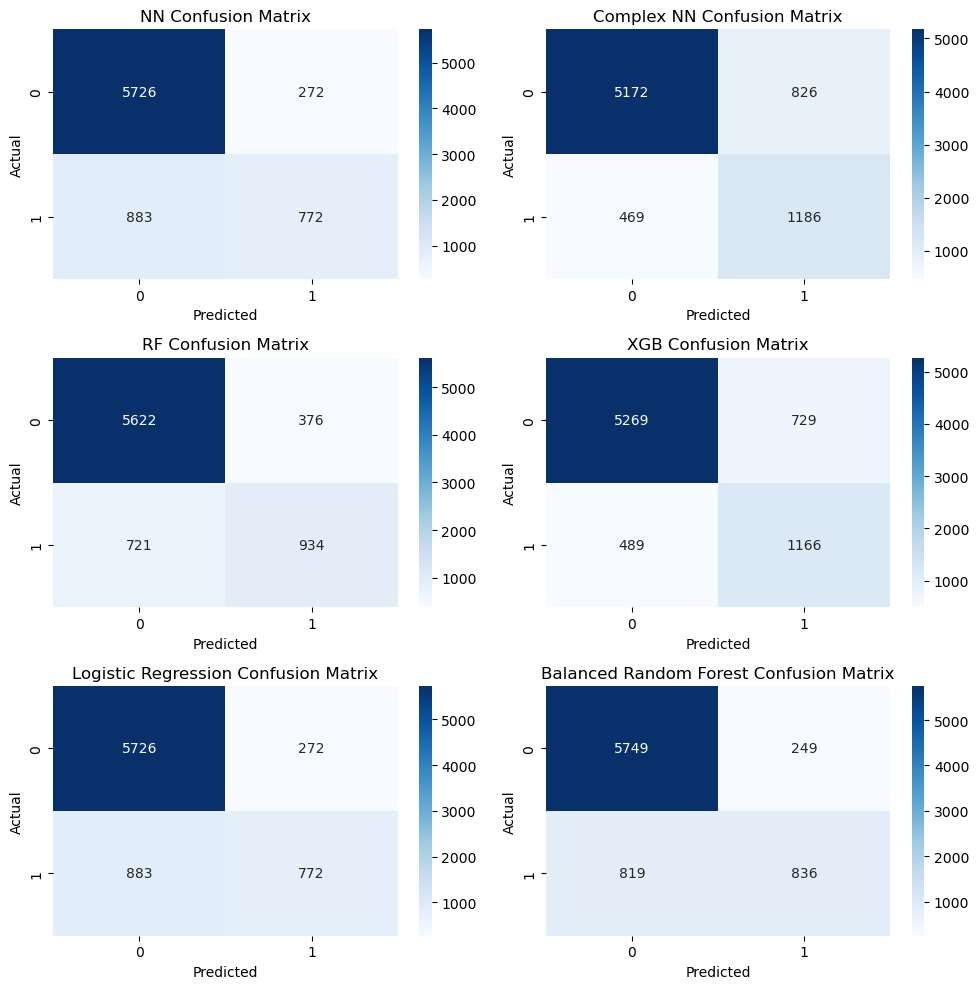

In [ ]:
#plot the confusion matrix
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
sns.heatmap(NN_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('NN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,2)
sns.heatmap(ComNN_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Complex NN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,3)
sns.heatmap(rf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,4)
sns.heatmap(xgb_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('XGB Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,5)
sns.heatmap(log_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,6)
sns.heatmap(brf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Balanced Random Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()